# FIT5202 Assignment 1 : Retail Analysis  Solution

## Table of Contents
* 
    * [Part 1 : Working with RDD](#part-1)
        * [1.1 Data Preparation and Loading](#1.1)
        * [1.2 Data Partitioning in RDD](#1.2)
        * [1.3 Query/Analysis](#1.3)
    * [Part 2 : Working with DataFrames](#2-dataframes)
        * [2.1 Data Preparation and Loading](#2-dataframes)
        * [2.2 Query/Analysis](#2.2)
    * [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)

# Part 1 : Working with RDDs <a class="anchor" name="part-1"></a>
## 1. Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries for retail analysis. 

### 1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkContext object using SparkSession, which tells Spark how to access a cluster. To create a SparkSession you first need to build a SparkConf object that contains information about your application, using Melbourne time as the session timezone. Give an appropriate name for your application and run Spark locally with as many working processors as logical cores on your machine. 

In [1]:
from pyspark import SparkConf

master = "local[*]"

app_name = "31171109 Assignment 1 FIT5202"

spark_conf = SparkConf().setMaster(master).setAppName(app_name)

from pyspark import SparkContext
from pyspark.sql import SparkSession


spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

1.1.2 For each features, sales and stores RDDs, remove the header rows and display the total count and first 10 records. Hint : You can use csv.reader to parse rows in RDDs.

In [2]:
import csv
feat_rdd = sc.textFile('Features.csv').map(lambda line: line.split(","))
feat_header=feat_rdd.first()
feat_rdd = feat_rdd.filter(lambda x:x != feat_header)
print(f"Feature RDD Total count:{feat_rdd.count()}")
print(f"First 10 records: {feat_rdd.take(10)}"+"\n")

sales_rdd = sc.textFile('sales.csv').map(lambda line: line.split(","))
sales_header = sales_rdd.first()
sales_rdd = sales_rdd.filter(lambda x:x != sales_header)
print(f"Sales RDD Total count:{sales_rdd.count()}")
print(f"First 10 records: {sales_rdd.take(10)}" +"\n")

stores_rdd = sc.textFile('stores.csv').map(lambda line: line.split(","))
stores_header = stores_rdd.first()

stores_rdd = stores_rdd.filter(lambda x:x != stores_header)
print(f"Store RDD Total count:{stores_rdd.count()}")
print(f"First 10 records: {stores_rdd.take(10)}"+"\n")

Feature RDD Total count:8190
First 10 records: [['1', '05/02/2010', '42.31', '2.572', 'NA', 'NA', 'NA', 'NA', 'NA', '211.0963582', '8.106', 'FALSE'], ['1', '12/02/2010', '38.51', '2.548', 'NA', 'NA', 'NA', 'NA', 'NA', '211.2421698', '8.106', 'TRUE'], ['1', '19/02/2010', '39.93', '2.514', 'NA', 'NA', 'NA', 'NA', 'NA', '211.2891429', '8.106', 'FALSE'], ['1', '26/02/2010', '46.63', '2.561', 'NA', 'NA', 'NA', 'NA', 'NA', '211.3196429', '8.106', 'FALSE'], ['1', '05/03/2010', '46.5', '2.625', 'NA', 'NA', 'NA', 'NA', 'NA', '211.3501429', '8.106', 'FALSE'], ['1', '12/03/2010', '57.79', '2.667', 'NA', 'NA', 'NA', 'NA', 'NA', '211.3806429', '8.106', 'FALSE'], ['1', '19/03/2010', '54.58', '2.72', 'NA', 'NA', 'NA', 'NA', 'NA', '211.215635', '8.106', 'FALSE'], ['1', '26/03/2010', '51.45', '2.732', 'NA', 'NA', 'NA', 'NA', 'NA', '211.0180424', '8.106', 'FALSE'], ['1', '02/04/2010', '62.27', '2.719', 'NA', 'NA', 'NA', 'NA', 'NA', '210.8204499', '7.808', 'FALSE'], ['1', '09/04/2010', '65.86', '2.77', '

### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 How many partitions do the above RDDs have? Hint: You can write code to obtain these answers. Can you explain Why it will be partitioned in this number?

In [3]:
print(f"Features No. of Partition: {feat_rdd.getNumPartitions()}")
print(f"Sales No. of Partition: {sales_rdd.getNumPartitions()}")
print(f"Stores No. of Partition: {stores_rdd.getNumPartitions()}")

Features No. of Partition: 2
Sales No. of Partition: 2
Stores No. of Partition: 2


**Ans:**

In theory, I believe Spark determines the no. of partitions based on different factors.

From the [documentation](https://spark.apache.org/docs/latest/rdd-programming-guide.html#:~:text=By%20default%2C%20Spark%20creates%20one,by%20passing%20a%20larger%20value), we can see that Spark default block size in HDFS is 128 MB and it create a partition for one block of file. Our current files should all within 128 MB. 

Features.csv : 600 KB

sales.csv : 13.3 MB

stores.csv : 577 bytes

As we can see, all of the files are within 128MB and thus the reason why they are all partitioned into 2 partitions may be due to the cluster configuration instead. 

Spark by default uses total no. of cores in the cluster to calculate the no. of partitions and then adjust it based on other factors. Therefore, for all 3 RDDs from different sized csv to be partitioned into 2 may be due to so. 

1.2.2. Create a key value RDD for the store RDD, use the store type as the key and all of columns as the value. Print out the first 5 records of the key-value RDD. 

In [4]:
def parse_store_keyvalue(line):
    key = line[1] # store type as the key
    value = line  # all of the columns as value 
    return (key,value)

stores_keyvalue= stores_rdd.map(parse_store_keyvalue)

print(stores_keyvalue.take(5))

[('A', ['1', 'A', '151315']), ('A', ['2', 'A', '202307']), ('B', ['3', 'B', '37392']), ('A', ['4', 'A', '205863']), ('B', ['5', 'B', '34875'])]


1.2.3. Write the code to seperate the store key-value RDD based on the store type (each type should be in the same partition). Print out the total partition's number and the number of records in each partition. 

In [5]:
# We can see that there are 3 store types : A, B and C

stores_rdd_partition = stores_keyvalue.repartition(3)
sorted_store_partition=stores_rdd_partition.sortByKey()

In [6]:
def printPartitions(store):
    noOfPartitions = store.getNumPartitions()
    print(f"Total partitions: {numPartitions}")
    partitions = store.glom().collect()
    for index,partition in enumerate(partitions):
        print(f'--Partition {index}:')
        count = 0
        for record in partition:
            count +=1
        print(count)

# printPartitions(sorted_store_partition)


In [7]:
# Display to show the partitions
# sorted_store_partition.glom().collect()

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

**1.3.1 Find and display the number of records in the sales RDD with weekly sales between 1000 and 50000**

In [8]:
sales_record = sales_rdd.filter(lambda x: float(x[3])>=1000 and float(x[3])<=50000)
print(f'The number of records: {sales_record.count()}')
print(f'Displaying records:')
# sales_record.collect()

The number of records: 316067
Displaying records:


**1.3.2 Calculate the average weekly sales for each year.**

In [25]:
sales_date= sales_rdd.map(lambda l: (l[2].split('/'),l[3])).map(lambda a: (a[0][2],float(a[1])))
dummyTuple = (0,0) 
sales_date=sales_date.aggregateByKey(dummyTuple, lambda a,b: (a[0] + b,    a[1] + 1),
                                       lambda a,b: (a[0] + b[0], a[1] + b[1]))
sales_date = sales_date.mapValues(lambda v: v[0]/v[1])
sales_date.collect()

[('2010', 16270.27573703275),
 ('2011', 15954.070675386221),
 ('2012', 15694.948597357119)]

<div style="background:rgba(255,181,116,0.5);padding:10px">
    <strong>NOTE:</strong> Other ways are also acceptable if they can get the correct result. 
    

</div>

**1.3.3 Find the highest temperature record in 2011 in the 'type B' store. You should display the store ID, date, highest temperature and type in the result.**

In [26]:
#Get all B store ID 
all_B_stores= stores_rdd.filter(lambda x : x[1]=='B').map(lambda l: (l[0],l[1]))

# Get all store temperature and date by their ID as key
store_temp = feat_rdd.map(lambda x: (x[0],(x[1],x[2])))

# Filter by year 2011
store_temp_2011= store_temp.map(lambda l: (l[0],(l[1][0],l[1][1]),l[1][0].split("/")))\
.filter(lambda x: x[2][2]=="2011").map(lambda l: (l[0],(l[1][0],l[1][1])))

# Join based on store id 
joined_B_stores = store_temp_2011.join(all_B_stores)

max_temp_2011 = joined_B_stores.max(key=lambda x: x[1][0][1])
max_temp_2011

('10', (('01/07/2011', '95.36'), 'B'))

## Part 2. Working with DataFrames <a class="anchor" name="2-dataframes"></a>
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

**2.1.1. Load features, sales and stores data into three separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each columns (Note: you could directly read the date column as the string type)**

In [29]:
feat_df = spark.read.csv("Features.csv",header=True,inferSchema = True)
sales_df= spark.read.csv("sales.csv",header=True,inferSchema = True)
stores_df= spark.read.csv("stores.csv",header=True,inferSchema = True)

**2.1.2 Display the schema of the features, sales and stores dataframes.**

In [31]:
print("Feature:")
feat_df.printSchema()
print("Sales:")
sales_df.printSchema()
print("Stores:")
stores_df.printSchema()

Feature:
root
 |-- Store: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

Sales:
root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

Stores:
root
 |-- Store: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)



### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API. The following DF means dataframes.

**2.2.1. Transform 'Date' column in both feature and sales dataframe to the date type, after that print out these two DFs schema to show the results.**

In [33]:
from pyspark.sql.functions import *

# For Feature dataframe 

feat_df = feat_df.withColumn("Date",to_date(col("Date"),"dd/MM/yyyy"))

feat_df.printSchema()

feat_df.show()

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|2010-02-05|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|
|  

In [34]:
#For sales dataframe

sales_df = sales_df.withColumn("Date",to_date(col("Date"),"dd/MM/yyyy"))

sales_df.printSchema()
sales_df.show()

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|2010-02-05|     24924.5|    false|
|    1|   1|2010-02-12|    46039.49|     true|
|    1|   1|2010-02-19|    41595.55|    false|
|    1|   1|2010-02-26|    19403.54|    false|
|    1|   1|2010-03-05|     21827.9|    false|
|    1|   1|2010-03-12|    21043.39|    false|
|    1|   1|2010-03-19|    22136.64|    false|
|    1|   1|2010-03-26|    26229.21|    false|
|    1|   1|2010-04-02|    57258.43|    false|
|    1|   1|2010-04-09|    42960.91|    false|
|    1|   1|2010-04-16|    17596.96|    false|
|    1|   1|2010-04-23|    16145.35|    false|
|    1|   1|2010-04-30|    16555.11|    false|
|    1|   1|2010-05-07|    17413.94|    false|


**2.2.2. Calculate the average weekly sales for holiday week and non-holiday week seperately, order your result based on the average weekly sales in descending order. Print out the IsHoliday and average sales columns**

In [72]:
import pyspark.sql.functions as F

#Separate holiday weeks and non-holiday weeks then average the sales in descending order. 
avg_sales_holiday= sales_df.groupby("IsHoliday").agg(F.avg("Weekly_Sales").alias("Average_Sales")).sort('Average_Sales',ascending=False)
avg_sales_holiday.show()

+---------+------------------+
|IsHoliday|     Average_Sales|
+---------+------------------+
|     true| 17035.82318735039|
|    false|15901.445069008767|
+---------+------------------+



**2.2.3.Based on different years and months, calculate the average weekly sales.**

In [73]:
#extract Year and Month 
avg_sales_ym =sales_df.withColumn("Year", year("Date"))
avg_sales_ym= avg_sales_ym.withColumn("Month", month("Date"))

#Group by Year and Month for avg weekly sales
avg_sales_ym=avg_sales_ym.groupby('Year','Month').agg(F.avg("Weekly_Sales").alias("Average_Sales")).sort('Year',"Month")
avg_sales_ym.show()

+----+-----+------------------+
|Year|Month|     Average_Sales|
+----+-----+------------------+
|2010|    2| 16076.77870090377|
|2010|    3|15432.626611808613|
|2010|    4|15745.551340409585|
|2010|    5|15996.481694653883|
|2010|    6|16486.250952748498|
|2010|    7|15972.812717533121|
|2010|    8| 16171.68929500989|
|2010|    9|15120.086691402259|
|2010|   10|14806.151497920526|
|2010|   11|17320.130647199454|
|2010|   12|19570.351251779048|
|2011|    1|13997.773991449336|
|2011|    2|15870.141203475016|
|2011|    3|15182.972004571237|
|2011|    4|15361.895495049488|
|2011|    5| 15367.86448054148|
|2011|    6| 16188.12464300947|
|2011|    7|15724.738312700913|
|2011|    8| 16030.54247768807|
|2011|    9|14961.570247273217|
+----+-----+------------------+
only showing top 20 rows



**2.2.4. Calculate and display the average MarkDown1 value in holiday week for each of the type-C stores.**

In [92]:
#Get stores with C type
all_C_stores= stores_df.filter(stores_df.Type=='C')

# Select necessary columns 
md_holiday = feat_df.select(feat_df.Store,feat_df.MarkDown1,feat_df.IsHoliday)

#Prep the C Store DF, changing its "Store" column name so we wont have repeated name
all_C_stores = all_C_stores.withColumnRenamed('Store', 'join_store')

#Join all C Stores only and the Feature with Markdown and IsHoliday value
joined_store_md = md_holiday.join(all_C_stores,md_holiday.Store==all_C_stores.join_store,how='inner')

#Filter holiday weeks and available MD values
joined_store_md=joined_store_md.filter((joined_store_md.MarkDown1 != "NA") & (joined_store_md.IsHoliday == True) )

# Select necessary columns only
cstore_md=joined_store_md.select(joined_store_md.Store,joined_store_md.MarkDown1)

#Then group by Store and average the MD1 values, Sort by MD1 values
avg_md_hol = cstore_md.groupby("Store").agg(F.avg("MarkDown1").alias("Average_MarkDown1")).sort('Average_MarkDown1',ascending=True)

#Display result
avg_md_hol.show()


+-----+------------------+
|Store| Average_MarkDown1|
+-----+------------------+
|   42|445.26142857142855|
|   37|            583.73|
|   43| 629.8657142857144|
|   30| 806.7442857142858|
|   44|           1042.64|
|   38|           1199.03|
+-----+------------------+



**2.2.5.Show the total sales for each month and the yearly total in 2011 for each different store, only keep two decimal places after the decimal point.**

In [93]:
#extracting Year and Month then create new column for respective 
ym_sales = sales_df.withColumn("Year", year("Date"))
ym_sales= ym_sales.withColumn("Month", month("Date"))

#Filter out 2011 only
sales_2011 = ym_sales.filter(ym_sales.Year == 2011)

# Group based on Store and Month, then sum the Weekly sales up to provide Monthly Sales
total_ym_sales=sales_2011.groupby('Store','Month').agg(F.sum("Weekly_Sales").alias("Monthly_Sales")).sort('Store',"Month")



In [94]:
from pyspark.sql.functions import lit

# Group based on Store again so that we can sum all the Monthly Sales up to a Yearly sales
yr_2011=total_ym_sales.groupby('Store').agg(F.sum("Monthly_Sales").alias("Monthly_Sales")).sort('Store')

# Create a Month column with default value 0
yr_2011=yr_2011.withColumn('Month', lit(0))

# Rearrange the columns to prep for joining 
yr_2011= yr_2011.select('Store',"Month","Monthly_Sales")

# Union two dataframe, one with Yearly Sales, one with Monthly Sales
unionDF = total_ym_sales.union(yr_2011).sort("Store","Month")


In [95]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import StringType

# Then we change Month to be a StringType so that we can replace the text later
unionDF = unionDF.withColumn("Month", unionDF['Month'].cast(StringType()))

unionDF = unionDF.replace("0", "Total", "Month")


In [96]:

from pyspark.sql.functions import format_number

# Rename column to fit the expected output in the assignment specs
unionDF = unionDF.withColumnRenamed("Monthly_Sales", "Sales")

# Format values to 2 decimal places
unionDF = unionDF.withColumn("Sales", format_number(unionDF["Sales"], 2))

unionDF.show()

+-----+-----+-------------+
|Store|Month|        Sales|
+-----+-----+-------------+
|    1|Total|80,921,918.83|
|    1|    1| 5,480,050.97|
|    1|    2| 6,399,887.57|
|    1|    3| 6,307,375.48|
|    1|    4| 7,689,123.60|
|    1|    5| 6,128,431.80|
|    1|    6| 6,194,971.74|
|    1|    7| 7,227,654.31|
|    1|    8| 6,144,985.73|
|    1|    9| 7,379,542.34|
|    1|   10| 6,072,327.75|
|    1|   11| 6,864,972.83|
|    1|   12| 9,032,594.71|
|    2|Total|98,607,881.42|
|    2|    1| 6,949,000.95|
|    2|    2| 8,011,783.74|
|    2|    3| 7,529,434.80|
|    2|    4| 9,136,076.69|
|    2|    5| 7,162,271.09|
|    2|    6| 7,607,607.16|
+-----+-----+-------------+
only showing top 20 rows



**2.2.6. Draw a scatter plot to show the relationship between weekly sales and unemployment rate. After that, discuss your findings based on the scatter plot**

In [134]:
# Get the Unemployment information 
unemployment= feat_df.select( feat_df.Store,feat_df.Date,feat_df.Unemployment)
unemployment = unemployment.groupby('Store','Date').agg(F.avg('Unemployment').alias('Unemployment'))

# Get the Weekly Sales 
weekly_sales= sales_df.groupby('Store','Date').agg(F.avg('Weekly_Sales').alias('Weekly_Sales'))

#Join them
joined= unemployment.join(weekly_sales, ['Store','Date'])
joined.show()

+-----+----------+------------+------------------+
|Store|      Date|Unemployment|      Weekly_Sales|
+-----+----------+------------+------------------+
|    1|2010-03-05|       8.106|21298.721643835615|
|    1|2010-04-02|       7.808| 22152.33722222222|
|    1|2011-12-16|       7.866|       26127.45375|
|    2|2010-03-26|       8.324|23975.312465753424|
|    2|2012-03-30|       7.057|26161.701971830982|
|    2|2012-07-27|       6.565| 24081.14904109589|
|    3|2012-10-26|       6.034| 6334.885937500001|
|    4|2010-04-30|       7.896|25595.398309859156|
|    4|2011-10-21|       5.143|30663.085138888895|
|    4|2012-07-27|       4.077|29265.909285714286|
|    6|2011-10-07|       6.551|20297.797260273972|
|    8|2011-11-18|       6.123|13000.466521739132|
|   15|2012-09-07|       8.193| 8389.426000000001|
|    3|2010-04-30|       7.343| 5473.460454545452|
|    5|2010-07-02|       6.496| 5016.283114754098|
|    6|2010-11-19|       7.007| 21392.13309859154|
|    7|2012-01-27|       8.256|

<AxesSubplot: title={'center': 'Weekly Sales vs Unemployment Rate'}, xlabel='Unemployment Rate', ylabel='Average Weekly Sales'>

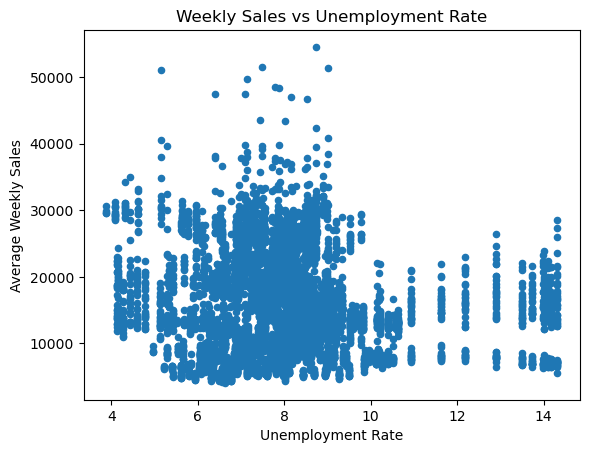

In [135]:

import matplotlib.pyplot as plot


panda_joined = joined.toPandas()

panda_joined.plot(x ="Unemployment",y="Weekly_Sales",kind="scatter", title = "Weekly Sales vs Unemployment Rate",xlabel = "Unemployment Rate", ylabel="Average Weekly Sales")



<div style="background:rgba(255,181,116,0.5);padding:10px">
    <strong>NOTE:</strong> When the unemployment rate is larger than 10, it will have a big influence on weekly sales. 

</div>

**Ans:**

We can see that once Unemployment rate is larger than 10, the Weekly sales are all less than 30000 on average and it appears to be lesser sales with lesser dots shown. This means that 10 is the threshold where once the unemployment rate reaches that threshold, weekly sales will be affected. By definition, we understand unemployment rate may be referring to percentage of unemployed individuals during that time. In this case, it may be the percentage of unemployed individuals around the store at that time. This may suggest that the higher the percentage of unemployed individuals, the lesser potential customer with disposable income which may then lead to a drop in the weekly sales. 


### Part 3 RDDs vs DataFrame vs Spark SQL (15%) <a class="anchor" name="part-3"></a>
Implement the following queries using RDDs, DataFrames and SparkSQL separately. Log the time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the computational performance difference of these 3 approaches.


#### Query: Calculate and display the average weekly fuel price for each store.
Discuss Why DF is faster than RDD? 

#### 3.1. For RDD

In [9]:
%%time
rdd_fuel= feat_rdd.map(lambda l: (int(l[0]),float(l[3])))
dummyTuple = (0,0) 
rdd_fuel=rdd_fuel.aggregateByKey(dummyTuple, lambda a,b: (a[0] + b,    a[1] + 1),
                                       lambda a,b: (a[0] + b[0], a[1] + b[1]))
rdd_fuel = rdd_fuel.mapValues(lambda v: v[0]/v[1])
# rdd_fuel.sortByKey().collect()


CPU times: user 7.35 ms, sys: 4.97 ms, total: 12.3 ms
Wall time: 17.9 ms


#### 3.2. For DataFrame

In [137]:
%%time

df_3=feat_df.groupby("Store").agg(F.avg('Fuel_Price').alias('avg(Fuel_Price)')).sort('Store')
df_3.show()

+-----+------------------+
|Store|   avg(Fuel_Price)|
+-----+------------------+
|    1|3.2592417582417585|
|    2|3.2592417582417585|
|    3|3.2592417582417585|
|    4|3.2548846153846167|
|    5|3.2592417582417585|
|    6|3.2592417582417585|
|    7|3.2944010989010994|
|    8|3.2592417582417585|
|    9|3.2592417582417585|
|   10|3.6156483516483515|
|   11|3.2592417582417585|
|   12|3.6436538461538466|
|   13| 3.328763736263738|
|   14|3.4764120879120877|
|   15| 3.643357142857142|
|   16|3.2944010989010994|
|   17| 3.328763736263738|
|   18|3.4978736263736243|
|   19| 3.643357142857142|
|   20|3.4764120879120877|
+-----+------------------+
only showing top 20 rows

CPU times: user 5.81 ms, sys: 3.17 ms, total: 8.98 ms
Wall time: 79.4 ms


#### 3.3. For Spark SQL

In [136]:
%%time

feat_df.createOrReplaceTempView("Features")
spark.sql("SELECT STORE, AVG(Fuel_Price) FROM FEATURES GROUP BY STORE ORDER BY STORE").show()

+-----+------------------+
|STORE|   avg(Fuel_Price)|
+-----+------------------+
|    1|3.2592417582417585|
|    2|3.2592417582417585|
|    3|3.2592417582417585|
|    4|3.2548846153846167|
|    5|3.2592417582417585|
|    6|3.2592417582417585|
|    7|3.2944010989010994|
|    8|3.2592417582417585|
|    9|3.2592417582417585|
|   10|3.6156483516483515|
|   11|3.2592417582417585|
|   12|3.6436538461538466|
|   13| 3.328763736263738|
|   14|3.4764120879120877|
|   15| 3.643357142857142|
|   16|3.2944010989010994|
|   17| 3.328763736263738|
|   18|3.4978736263736243|
|   19| 3.643357142857142|
|   20|3.4764120879120877|
+-----+------------------+
only showing top 20 rows

CPU times: user 6.14 ms, sys: 1.19 ms, total: 7.33 ms
Wall time: 107 ms


#### Summary

The time might differ when running on different machines. Overall, the DataFrame and SQL queries run faster compared with RDD.

RDD : 171ms 

DF : 79.4ms 

SQL : 107ms

As to why DF are faster than RDD may be due to serialization of individual Java and Scala objects takes more time in running RDD compared to the use of off-heap memory for serialization which occurs in DF. DF minimizes overhead, resulting it being faster than RDD. 

### Declaration of use of Generative AI 

I acknowledge the use of generative AI. 1.2.1, 2.2.6 and Part 3 explanations involves the use of ChatGPT. 
ChatGPT are used in summarizing what Spark documentations are about and also, re-explaining the resource online such as how does Spark make use of HDFS block size to determine number of partitions. The use of the AI tool is mainly for understanding of how Spark works by default and its nature with RDD and Dataframes. Answers are written on my own and not paraphrase from ChatGPT as it does provides some false information such as HDFS default block size being 64 MB instead of the online resources and documentations confirmed information : 128MB.



### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html